In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P", "ENG"]
    drop_cols = []
    for i in cols:
        drop_first = f'{i}_{df_processed[i].value_counts().idxmax()}'
        drop_cols.append(drop_first)
        df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=[i]).drop(columns=drop_first)
    # df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    # df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex, drop_cols

data, data_original, target, group, drop_cols = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [2]:
# Using Random Forest to Classify if target is above income threshold

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, threshold1, threshold2):
    global s1, s2, preds_s1, preds_s2, true_s1, true_s2, fpr1, tpr1, thresholds1, fpr2, tpr2, thresholds2, scores_s1, scores_s2   
    pipeline.fit(X_train, y_train)
    # y_pred = pipeline.predict(X_test)
    # Modify pipeline to fulfill one of the fairness criteria (e.g. statistical parity, equal opportunity, etc.)
    X_test = X_test.reset_index(drop=True)
    s2 = X_test.query("SEX_2 == True")
    s1 = X_test.query("SEX_2 == False")

    true_s1 = []
    for i in s1.index:
        true_s1.append(y_test[i])
    true_s2 = []
    for i in s2.index:
        true_s2.append(y_test[i])


    scores_s1 = pipeline.predict_proba(s1)[:, 1]
    fpr1, tpr1, thresholds1 = roc_curve(true_s1, scores_s1, pos_label=1)
    scores_s2 = pipeline.predict_proba(s2)[:, 1]
    fpr2, tpr2, thresholds2 = roc_curve(true_s2, scores_s2, pos_label=1)


    preds_s1 = scores_s1 > threshold1
    preds_s2 = scores_s2 > threshold2
    return pipeline

In [4]:
# Needed to make sure logisric regression converges
X_train['AGEP'] = StandardScaler().fit_transform(X_train[['AGEP']])
X_test['AGEP'] = StandardScaler().fit_transform(X_test[['AGEP']])


In [5]:
rf_args = {
    'n_estimators': 100, # changed from 100
    'max_depth' : 10, #changed from 10
    'min_samples_split': 2, #changed from 2
    'min_samples_leaf': 2, #changed from 2
    'random_state': 0
}
lr_model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga", random_state=0)
p1 = make_pipeline(RandomForestClassifier(**rf_args))
p2 = make_pipeline(lr_model)

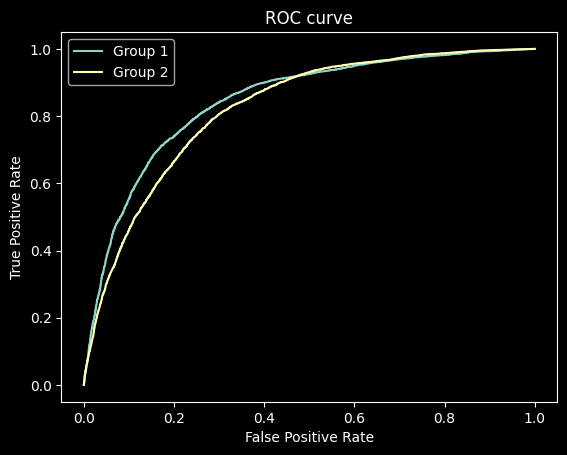

Accuracy for group 1:  0.7627176179622714
Accuracy for group 2:  0.7523228176318064
Selection rate for s1:  0.5272780175549198
Selection rate for s2:  0.5466724286949006
Statistical parity:  0.01939441113998086


In [6]:
p2_done = evaluate_pipeline(p2, X_train, y_train, X_test, y_test, 0.4, 0.5)

plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]
preds_s1 = scores_s1 > 0.66 # 0.66 best 
preds_s2 = scores_s2 > optimal_threshold2 # 0.4756088801681863 best

print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))

print('Selection rate for s1: ', np.sum(preds_s1)/len(s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(s2))

statistical_parity = np.sum(preds_s1)/len(s1) - np.sum(preds_s2)/len(s2)
print('Statistical parity: ', abs(statistical_parity))


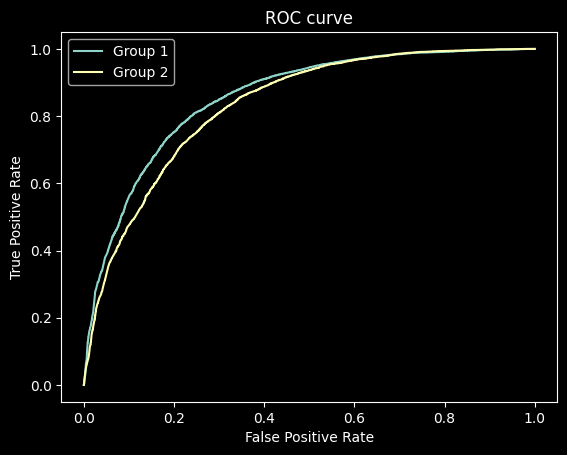

Accuracy for group 1:  0.7838126182047427
Accuracy for group 2:  0.7541594641313742
Selection rate for s1:  0.7326511808350711
Selection rate for s2:  0.5677398444252377
Statistical parity:  0.16491133640983335


In [7]:
p1_done = evaluate_pipeline(p1, X_train, y_train, X_test, y_test, 0.4, 0.5)

plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]
preds_s1 = scores_s1 > 0.66 # 0.66 best 
preds_s2 = scores_s2 > optimal_threshold2 # 0.4756088801681863 best
# Compare outcomes across groups

p1_done = evaluate_pipeline(p1, X_train, y_train, X_test, y_test, 0.401, optimal_threshold2)
print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))

print('Selection rate for s1: ', np.sum(preds_s1)/len(s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(s2))

statistical_parity = np.sum(preds_s1)/len(s1) - np.sum(preds_s2)/len(s2)
print('Statistical parity: ', abs(statistical_parity))

### Changes to be made to models
The accuracy of the classifier sits at 0.77 as of baseline test with the selected pipeline. Standard-scaling was used across all features, which may end up causing trouble. The model has a fairly high accuracy for a baseline classifier, with desirable f1-scores at [0.72, 0.81]. Since the outcome variable in this case is almost equally balanced at the chosen threshold, we need not to scale our model much with respect to the outcome variable. In this pipeline discrete variables are scaled, which changes the otherwise explainable binary variables, which hurts the explainability of the model. <br>
<br>
We would need to only scale the age column in the data to fix this explainability issue. Unless we had more continuous ways of representing the discrete variables in the data (such as language test scores for english proficiency, SAT scores for education etc.) we would not be able to quantify these columns in any meaningful fashion.

### What we did
In trying to improve the interpretability of our model, we limit the scaling to exclusively be applied to the "AGEP" column, seeing as it is the only continuous variable in the data. We also use the template's onehot-encodings applied to the discrete variables, with dropping the first value applied. This way we can compare each categorical variable to the baseline of the one which is dropped. <br>

Before making any changes to any of the models we find the following accuracies of the classifiers: 
<br>
(insert classification report for models)
<br>



### 